# Data Expedition 2020 - Group 2 Agility

## Investigtion into the relationship between crime and weather

### Research Questions
Are there seasonal patterns of crime? <br>
&nbsp;&nbsp;&nbsp;&nbsp; Are crime rates different between summer and winter? <br>
&nbsp;&nbsp;&nbsp;&nbsp; Does this pattern differ for specific types of crime?<br>
What is the connection between crime and weather? <br>
&nbsp;&nbsp;&nbsp;&nbsp; Do some types of crime have more correlation to weather than others?<br>
&nbsp;&nbsp;&nbsp;&nbsp; What is the most common type of crime in summer? In Winter? <br>

### Data Sources

Crime data:
https://data.police.uk/docs/method/crimes-at-location/
- Leeds 2017 - 2020
- Downloaded as csv

Weather data:
https://sci.ncas.ac.uk/leedsweather/tabular.html?report=NOAA/NOAA-2018.txt
- Leeds 2017 - 2020
- Downloaded as csv files, per weather type (temperature, precipitation, wind)

## Set up modules and working directory

In [1]:
#import modules
import os #operating system
import pandas as pd #for dataframes
import numpy as np #arrays
import matplotlib.pyplot as plt #for plotting
from matplotlib.patches import Patch #for legend in plots, where colour patches needed
from matplotlib.lines import Line2D #for lines in plot legends
from datetime import datetime #for converting dates to datetime
import re #regular expressions, string matching
from itertools import chain #for unlisiting
from sklearn.linear_model import LinearRegression #linear regression
import seaborn #for correlation matrix

In [2]:
#set working directory
wdir = 'D:\Projects\Data Expedition'
os.chdir(wdir)

## Crime data and seasonality (with meterological seasons)

### Organise data

In [3]:
# read in crime data
df = pd.read_csv(wdir + '\Leeds - full crime.csv')
df.head()

,Unnamed: 0,Month,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Date,Year
0,0,7,-1.706334,53.549364,On or near Brown'S Edge Road,E01007426,Barnsley 027D,Burglary,Investigation complete; no suspect identified,2017-07-01,2017
1,1,7,-1.670108,53.553629,On or near Huddersfield Road,E01007426,Barnsley 027D,Theft from the person,Investigation complete; no suspect identified,2017-07-01,2017
2,2,7,-1.865236,53.936782,On or near Ilkley Road,E01010646,Bradford 001A,Anti-social behaviour,NaN,2017-07-01,2017
3,3,7,-1.862963,53.937750,On or near Old Lane,E01010646,Bradford 001A,Anti-social behaviour,NaN,2017-07-01,2017
4,4,7,-1.881467,53.944510,On or near Kilners Croft,E01010646,Bradford 001A,Other theft,Investigation complete; no suspect identified,2017-07-01,2017


In [4]:
df.shape #view shape, rows cols

(1001987, 11)

In [5]:
#new dataframe, grouped by data and crime type
clean_df = df.groupby('Date')['Crime type'].value_counts().unstack()
clean_df.shape

(36, 14)

In [6]:
#calculate total per month and add to dataframe at end
total_crime = clean_df.sum(axis = 1)
clean_df.insert(14, column = 'total_crime', value = total_crime)

In [7]:
#view new df

clean_df.head()

Crime type,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,total_crime
Date,,,,,,,,,,,,,,,
2017-07-01,5955,243,2231,2714,480,526,2399,158,2091,247,1561,333,2096,7503,28537
2017-08-01,6175,300,2319,2616,459,544,2305,134,1815,235,1414,371,1879,6758,27324
2017-09-01,4967,251,2399,2578,480,533,2154,161,1827,186,1543,297,2026,7077,26479
2017-10-01,6251,294,2528,3220,451,628,2336,168,1978,268,1552,378,2200,7679,29931
2017-11-01,5016,211,2339,3140,493,614,2238,145,1811,267,1711,432,2101,7544,28062


### Visualisations

#### Set up data for visualisations

In [8]:
#get all dates from df
datelist = list(clean_df.index)
#create regex expressions for search
seasonsearch = ['.*-03-01', '.*-06-01','.*-09-01','.*-12-01' ]

#empty list to store
seasons = []
# for each seasonsearch, find match from datelist and put in season
for season in seasonsearch:
    r = re.compile(season)
    seasons.append(list(filter(r.match, datelist)))

#unpack list of lists
seasons = list(chain.from_iterable(seasons))
list.sort(seasons) #get into dateorder

seasons

['2017-09-01',
 '2017-12-01',
 '2018-03-01',
 '2018-06-01',
 '2018-09-01',
 '2018-12-01',
 '2019-03-01',
 '2019-06-01',
 '2019-09-01',
 '2019-12-01',
 '2020-03-01',
 '2020-06-01']

In [9]:
#add the date at the very start of the time series if it doesnt match season start
if datelist[0] != seasons[0]:
    seasons.insert(0, datelist[0])
    
seasons

['2017-07-01',
 '2017-09-01',
 '2017-12-01',
 '2018-03-01',
 '2018-06-01',
 '2018-09-01',
 '2018-12-01',
 '2019-03-01',
 '2019-06-01',
 '2019-09-01',
 '2019-12-01',
 '2020-03-01',
 '2020-06-01']

In [10]:
# set up colours for seasons
cols = ['#F4E04D', '#F68E5F', '#74A4BC', '#A1E887']
cols = cols*3
cols

['#F4E04D',
 '#F68E5F',
 '#74A4BC',
 '#A1E887',
 '#F4E04D',
 '#F68E5F',
 '#74A4BC',
 '#A1E887',
 '#F4E04D',
 '#F68E5F',
 '#74A4BC',
 '#A1E887']

In [11]:
# set up legend for seasons
legend_elements = [Patch(facecolor='#F4E04D', edgecolor='#F4E04D', label='Summer', alpha = 0.15),
                  Patch(facecolor='#F68E5F', edgecolor='#F68E5F', label='Autumn', alpha = 0.15),
                   Patch(facecolor='#74A4BC', edgecolor='#74A4BC', label='Winter', alpha = 0.15),
                   Patch(facecolor='#A1E887', edgecolor='#A1E887', label='Spring', alpha = 0.15),
                  ]

#### Visualisations

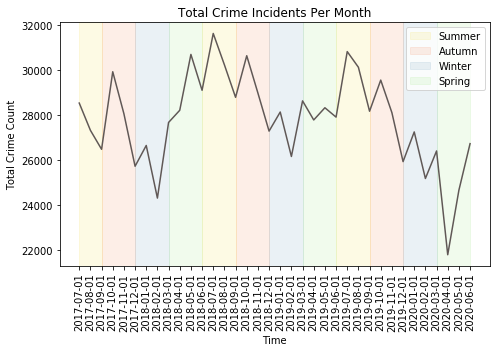

In [12]:
#total crime 

plt.figure(figsize=(7,5)) #figure dims
plt.plot(clean_df.loc['2017-07-01' : '2020-06-01' , 'total_crime'], color = '#605856') #data to plot and line colour
#plot the background shading
for i in range(0, len(seasons)-1):
        plt.axvspan(seasons[i],seasons[i+1], alpha=0.15, color=cols[i])
#plot labels
plt.ylabel('Total Crime Count')
plt.xlabel('Time')
plt.title('Total Crime Incidents Per Month')
#rotate axis ticks
plt.xticks(rotation = 90)
#plot legend
plt.legend(handles = legend_elements)
#ensure that labels arent clipped in export
plt.tight_layout()
#savefig
plt.savefig(wdir+'\TotalCrimePerMonth.png')
#display
plt.show()


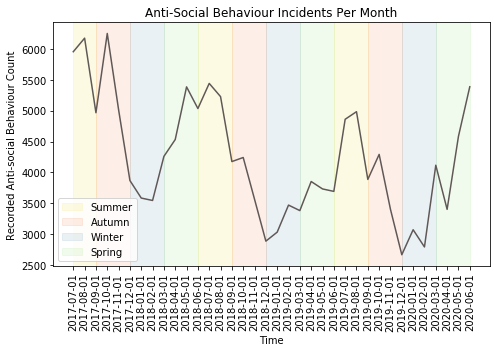

In [13]:
#anti social behaviour

plt.figure(figsize=(7,5)) #figure dims
plt.plot(clean_df.loc['2017-07-01' : '2020-06-01' , 'Anti-social behaviour'], color = '#605856') #data to plot and line colour
#plot the background shading
for i in range(0, len(seasons)-1):
        plt.axvspan(seasons[i],seasons[i+1], alpha=0.15, color=cols[i])
#plot labels
plt.ylabel('Recorded Anti-social Behaviour Count')
plt.xlabel('Time')
plt.title('Anti-Social Behaviour Incidents Per Month')
#rotate axis ticks
plt.xticks(rotation = 90)
#plot legend
plt.legend(handles = legend_elements)
#ensure that labels arent clipped in export
plt.tight_layout()
#savefig
plt.savefig(wdir+'\AntiSocialCrimePerMonth.png')
#display
plt.show()

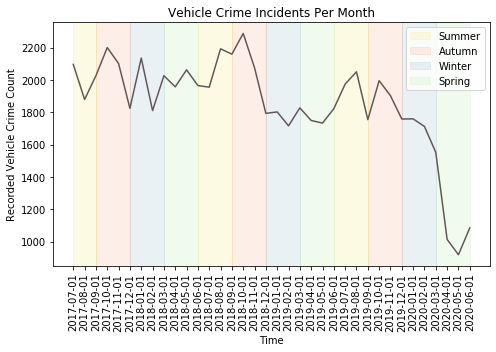

In [14]:
#vehicle crime

plt.figure(figsize=(7,5)) #figure dims
plt.plot(clean_df.loc['2017-07-01' : '2020-06-01' , 'Vehicle crime'], color = '#605856') #data to plot and line colour
#plot the background shading
for i in range(0, len(seasons)-1):
        plt.axvspan(seasons[i],seasons[i+1], alpha=0.15, color=cols[i])
#plot labels
plt.ylabel('Recorded Vehicle Crime Count')
plt.xlabel('Time')
plt.title('Vehicle Crime Incidents Per Month')
#rotate axis ticks
plt.xticks(rotation = 90)
#plot legend
plt.legend(handles = legend_elements)
#ensure that labels arent clipped in export
plt.tight_layout()
#savefig
plt.savefig(wdir+'\VehicleCrimePerMonth.png')
#display
plt.show()

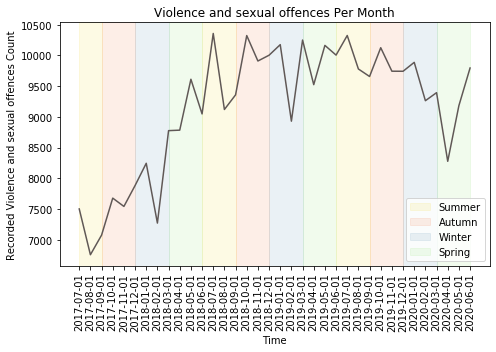

In [15]:
#Violence and sexual offences

plt.figure(figsize=(7,5)) #figure dims
plt.plot(clean_df.loc['2017-07-01' : '2020-06-01' , 'Violence and sexual offences'], color = '#605856') #data to plot and line colour
#plot the background shading
for i in range(0, len(seasons)-1):
        plt.axvspan(seasons[i],seasons[i+1], alpha=0.15, color=cols[i])
#plot labels
plt.ylabel('Recorded Violence and sexual offences Count')
plt.xlabel('Time')
plt.title('Violence and sexual offences Per Month')
#rotate axis ticks
plt.xticks(rotation = 90)
#plot legend
plt.legend(handles = legend_elements)
#ensure that labels arent clipped in export
plt.tight_layout()
#savefig
plt.savefig(wdir+'\ViolentCrimePerMonth.png')
#display
plt.show()

## Weather Data

### Organise data

In [16]:
#import weather data
temp = pd.read_csv(wdir + '\leeds_weather_temps.csv', skiprows = 6, index_col= False)
precip = pd.read_csv(wdir + '\leeds_weather_precip.csv', skiprows = 6, index_col= False)
wind = pd.read_csv(wdir + '\leeds_weather_wind.csv', skiprows = 6, index_col= False)

In [17]:
#dates as strings - cleaning
strdate = [] #empty list

#for every row in temp (each month) turn into format yy-mm-dd
for i in range(0, len(temp)):
    if len(str(temp.loc[i, 'month'])) == 1: #if the month is one digit add '0' 
        strdate.append(str(temp.loc[i,'year']) + '-0' + str(temp.loc[i, 'month']) + '-01') #concatenate values as date
    if len(str(temp.loc[i, 'month'])) == 2: #if month is two digits just concatenate
        strdate.append(str(temp.loc[i,'year']) + '-' + str(temp.loc[i, 'month']) + '-01') #concatenate
        

In [18]:
#temperature data
temp.insert(0, column = 'date', value = strdate) #add generate stringdates as date column for plots
temp = temp.drop([0,1,2,3,4,5,42,43], axis = 0) # drop rows that arent in crime data
temp = temp.set_index('date') #set date as index (row labels)
temp.head() #view data



,year,month,mean_max_T(C),mean_min_T(C),heating_degree_days,cooling_degree_days,temp_hi,temp_hi_day,temp_low,temp_low_day,temp_max>=30,temp_max<=0,temp_min<=0,temp_min<=-20
date,,,,,,,,,,,,,,
2017-07-01,2017,7,21.4,12.7,16.6,103.2,6.7,28.1,6,11.0,2,0,0,0
2017-08-01,2017,8,20.5,12.3,16.1,125.8,2.7,24.1,17,9.4,10,0,0,0
2017-09-01,2017,9,17.9,10.3,13.7,248.7,0.0,21.8,4,5.8,19,0,0,0
2017-10-01,2017,10,15.8,10.2,12.9,301.9,0.0,21.3,14,2.8,30,0,0,0
2017-11-01,2017,11,10.4,5.0,7.7,576.3,0.0,16.3,22,0.3,30,0,0,0


In [19]:
# wind data
wind.insert(0, column = 'date', value = strdate) #add generate stringdates as date column for plots
wind = wind.drop([0,1,2,3,4,5,42,43], axis = 0) # drop rows that arent in crime data
wind = wind.set_index('date') #set date as index (row labels)
wind.head()


,year,month,wind_average(ms),wind_hi,wind_hi_date,wind_dom_dir
date,,,,,,
2017-07-01,2017,7,1.7,11.2,24,258
2017-08-01,2017,8,1.5,12.1,3,249
2017-09-01,2017,9,1.5,13.0,13,242
2017-10-01,2017,10,2.0,19.2,16,243
2017-11-01,2017,11,1.7,16.5,22,271


In [20]:
#organise precipitation data
precip.insert(0, column = 'date', value = strdate) #add dates to match crime data
precip = precip.drop([0,1,2,3,4,5,42,43], axis = 0) #drop rows that arent in
precip = precip.set_index('date') #set date as index (row labels)
precip.head()

,year,month,total_precip(mm),precip_max_obs_(mm),precip_max_obs_date,days_of_rain_over_0.3mm,days_of_rain_over_3mm,days_of_rain_over_30mm
date,,,,,,,,
2017-07-01,2017,7,56.8,15.2,22,13,7,0
2017-08-01,2017,8,66.0,13.4,23,13,5,0
2017-09-01,2017,9,78.6,11.4,27,22,9,0
2017-10-01,2017,10,38.0,12.8,21,12,4,0
2017-11-01,2017,11,26.4,4.6,20,13,4,0


In [21]:
# complile all weather data into one dataframe
weather = temp.join(precip, lsuffix = '_temp', rsuffix = '_precip') #join precipitation to temperature
weather = weather.join(wind, rsuffix = '_wind') #join wind to weather
weather.head() #view outcome - large dataframe

,year_temp,month_temp,mean_max_T(C),mean_min_T(C),heating_degree_days,cooling_degree_days,temp_hi,temp_hi_day,temp_low,temp_low_day,...,precip_max_obs_date,days_of_rain_over_0.3mm,days_of_rain_over_3mm,days_of_rain_over_30mm,year,month,wind_average(ms),wind_hi,wind_hi_date,wind_dom_dir
date,,,,,,,,,,,,,,,,,,,,,
2017-07-01,2017,7,21.4,12.7,16.6,103.2,6.7,28.1,6,11.0,...,22,13,7,0,2017,7,1.7,11.2,24,258
2017-08-01,2017,8,20.5,12.3,16.1,125.8,2.7,24.1,17,9.4,...,23,13,5,0,2017,8,1.5,12.1,3,249
2017-09-01,2017,9,17.9,10.3,13.7,248.7,0.0,21.8,4,5.8,...,27,22,9,0,2017,9,1.5,13.0,13,242
2017-10-01,2017,10,15.8,10.2,12.9,301.9,0.0,21.3,14,2.8,...,21,12,4,0,2017,10,2.0,19.2,16,243
2017-11-01,2017,11,10.4,5.0,7.7,576.3,0.0,16.3,22,0.3,...,20,13,4,0,2017,11,1.7,16.5,22,271


#### Visualisation

In [22]:
#set up legend

custom_lines = [Line2D([0], [0], color='#D34E24', lw=1), #max temps line
                Line2D([0], [0], color='#38726C', lw=1) #min temps line
               ]


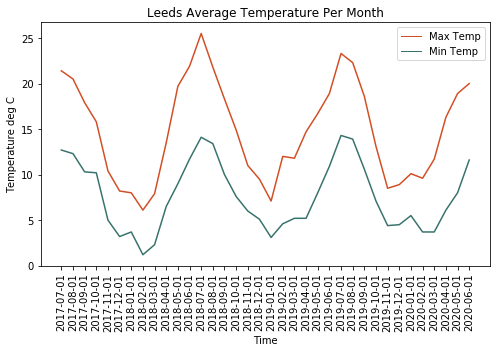

In [23]:
#average min max temperature per month
plt.figure(figsize=(7,5))
plt.plot(weather['mean_max_T(C)'], color = '#D34E24') #max temp line
plt.plot(weather['mean_min_T(C)'], color = '#38726C') #min temp line
plt.ylabel('Temperature deg C')
plt.xlabel('Time')
plt.title('Leeds Average Temperature Per Month')
plt.xticks(rotation = 90) #rotate dates so can read
plt.legend(custom_lines, ['Max Temp','Min Temp']) # legend using lines from cell above
plt.tight_layout() #prevents parts of plot being cut off in export
plt.savefig(wdir + '\Temps_perMonth.png') 
plt.show()

## Weather and Crime

### Set up and preliminary data exploration

In [24]:
weather_crime = weather.join(clean_df, rsuffix = '_crime') #join crime to weather

In [25]:
weather_crime.to_csv(wdir + '\weather_crime.csv' ) #export this as csv

In [26]:
cor_mat = weather_crime.corr() #calculate correlation matrix

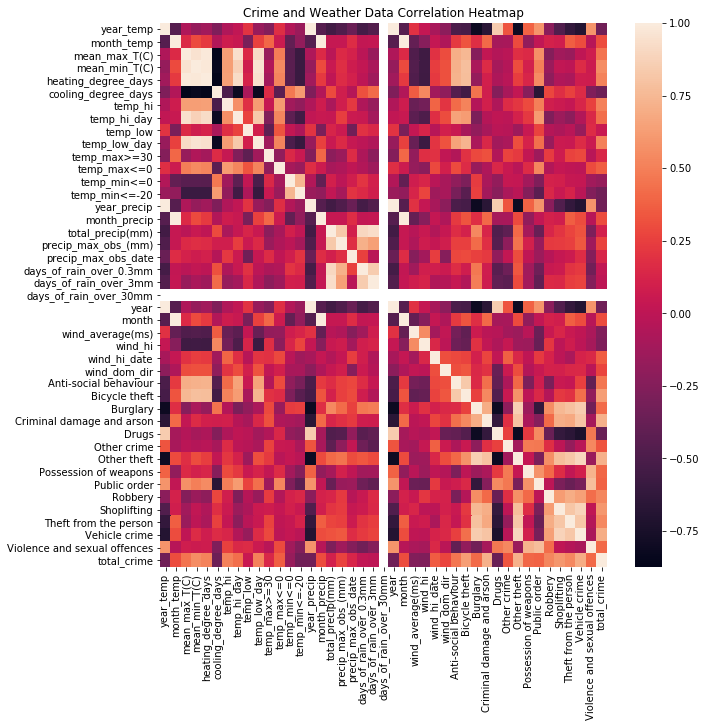

In [27]:
# view correlation matrix
plt.figure(figsize=(10,10))
seaborn.heatmap(cor_mat) #correlation matrix heatmap
plt.title('Crime and Weather Data Correlation Heatmap') #plot title
plt.savefig(wdir + '\crime_weather_corrmat.png') #export figure

In [28]:
cor_mat.to_csv(wdir + '\corrmat.csv' ) #export correlation matrix

For speed, here conditional formatting in excel was used to identify weather and crime variables which had absolute correlation > 0.5 <br>
These are the ones displayed below in visualisation<br>
Regression lines were calculated in R using lm() linear regression function from base stats (again for speed). <br>
The line equation for the regression was extracted and plotted as lines on graphs
### Visualisation of crime and weather variables

In [29]:
#temperature legend
custom_lines = [Line2D([0], [0], color='#D34E24', lw=1),
                Line2D([0], [0], color='#38726C', lw=1)
               ]


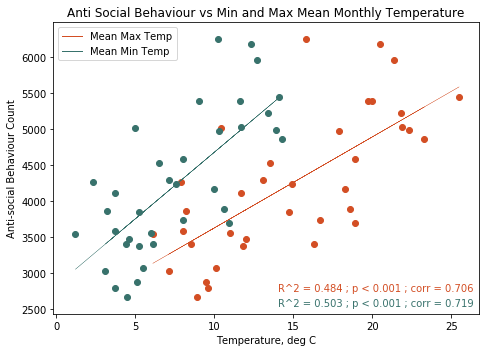

In [30]:
#anti social crime vs min and max temps
plt.figure(figsize=(7,5)) #figure proportions
#plot data
plt.scatter(weather_crime['mean_max_T(C)'],weather_crime['Anti-social behaviour'], color = '#D34E24')
plt.scatter(weather_crime['mean_min_T(C)'],weather_crime['Anti-social behaviour'], color = '#38726C')
# regression lines
plt.plot(weather_crime['mean_max_T(C)'], weather_crime['mean_max_T(C)']*126.09 + 2369.41, 
         'r', color = '#D34E24', linewidth = 0.25)
plt.plot(weather_crime['mean_min_T(C)'], weather_crime['mean_min_T(C)']*184.4 + 2835.21, 
         'r' , color = '#38726C',linewidth = 0.25)
#plot labels
plt.ylabel('Anti-social Behaviour Count')
plt.xlabel('Temperature, deg C')
plt.title('Anti Social Behaviour vs Min and Max Mean Monthly Temperature')
#legend
plt.legend(custom_lines, ['Mean Max Temp','Mean Min Temp'])
#additional info for plots
plt.text(14, 2750, 'R^2 = 0.484 ; p < 0.001 ; corr = 0.706', color = '#D34E24') #stats summary
plt.text(14, 2550, 'R^2 = 0.503 ; p < 0.001 ; corr = 0.719', color = '#38726C') #stats summary
plt.tight_layout() #ensure no plot loss in export
plt.savefig(wdir + '\Antisocial_Temps_scatter.png')
plt.show()


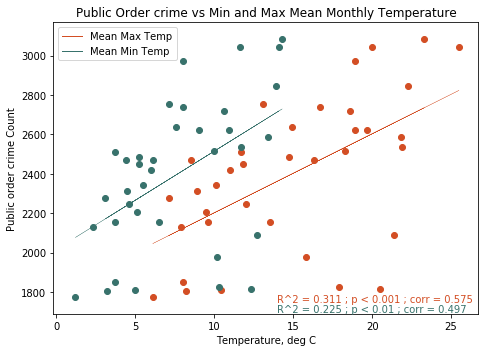

In [31]:
#public order crime vs min max temps
plt.figure(figsize=(7,5))
#plot data
plt.scatter(weather_crime['mean_max_T(C)'],weather_crime['Public order'], color = '#D34E24')
plt.scatter(weather_crime['mean_min_T(C)'],weather_crime['Public order'], color = '#38726C')
#regression lines
plt.plot(weather_crime['mean_max_T(C)'], weather_crime['mean_max_T(C)']*40.07 + 1801.62, 
         'r', color = '#D34E24',linewidth = 0.25)
plt.plot(weather_crime['mean_min_T(C)'], weather_crime['mean_min_T(C)']*49.79 + 2017.22, 
         'r' , color = '#38726C',linewidth = 0.25)
#plot labels
plt.ylabel('Public order crime Count')
plt.xlabel('Temperature, deg C')
plt.title('Public Order crime vs Min and Max Mean Monthly Temperature')
#legend
plt.legend(custom_lines, ['Mean Max Temp','Mean Min Temp'])
#stats details
plt.text(14, 1750, 'R^2 = 0.311 ; p < 0.001 ; corr = 0.575', color = '#D34E24')
plt.text(14, 1700, 'R^2 = 0.225 ; p < 0.01 ; corr = 0.497', color = '#38726C')
plt.tight_layout()
plt.savefig(wdir + '\PublicOrder_Temps_scatter.png')
plt.show()



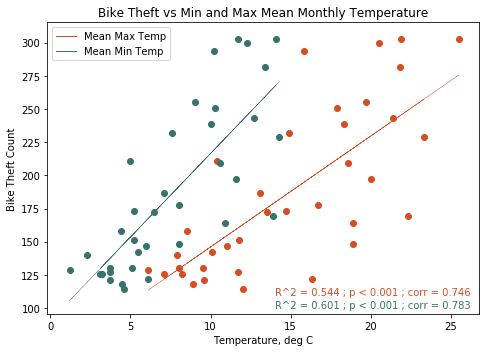

In [32]:
#bike theft vs min max temps
plt.figure(figsize=(7,5))
#plot data
plt.scatter(weather_crime['mean_max_T(C)'],weather_crime['Bicycle theft'], color = '#D34E24')
plt.scatter(weather_crime['mean_min_T(C)'],weather_crime['Bicycle theft'], color = '#38726C')
#regresion lines
plt.plot(weather_crime['mean_max_T(C)'], weather_crime['mean_max_T(C)']*8.365 + 62.395, 
         'r', color = '#D34E24', linewidth = 0.25)
plt.plot(weather_crime['mean_min_T(C)'], weather_crime['mean_min_T(C)']*12.603 + 90.497, 
         'r' , color = '#38726C', linewidth = 0.25)
#plot labels
plt.ylabel('Bike Theft Count')
plt.xlabel('Temperature, deg C')
plt.title('Bike Theft vs Min and Max Mean Monthly Temperature')
#legend
plt.legend(custom_lines, ['Mean Max Temp','Mean Min Temp'])
#stats summary
plt.text(14, 110, 'R^2 = 0.544 ; p < 0.001 ; corr = 0.746', color = '#D34E24')
plt.text(14, 100, 'R^2 = 0.601 ; p < 0.001 ; corr = 0.783', color = '#38726C')
plt.tight_layout()
plt.savefig(wdir + '\BikeTheft_Temps_scatter.png')
plt.show()


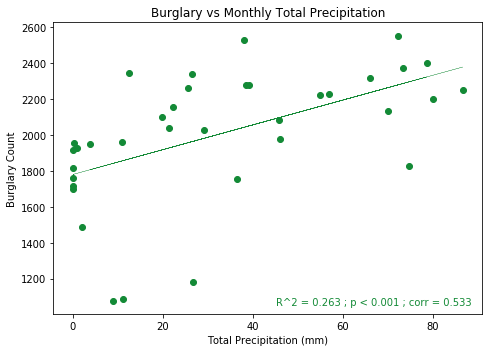

In [33]:
#burglary vs precipitation
plt.figure(figsize=(7,5))
#plot data
plt.scatter(weather_crime['total_precip(mm)'],weather_crime['Burglary'], color = '#138A36')
#regression line
plt.plot(weather_crime['total_precip(mm)'], weather_crime['total_precip(mm)']*6.911 + 1780.73, 'r' , 
         color = '#138A36', linewidth = 0.25)
#plot labels
plt.ylabel('Burglary Count')
plt.xlabel('Total Precipitation (mm)')
plt.title('Burglary vs Monthly Total Precipitation')
#stats summary
plt.text(45, 1050, 'R^2 = 0.263 ; p < 0.001 ; corr = 0.533', color = '#138A36')
plt.tight_layout()
plt.savefig(wdir + '\Burglary_precip_scatter.png')
plt.show()